In [1]:
import os
from astropy.io import fits
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py
from keras.preprocessing.image import ImageDataGenerator

In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only allocate 10GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [4]:
#prepare inputs


#prepare training

#use validaton set instead to speed things up:
hf = h5py.File('../../data/HSC/HSC_v6/five_band_image127x127_validation_with_metadata_with_scaled.hdf5', 'r')

x_train = hf["image"]
y_train = hf["specz_redshift"]
y_train = np.array(y_train)
x_train_mags_scaled = hf['scaled_mags']
x_train_mags_scaled = pd.DataFrame(x_train_mags_scaled)
x_train = np.transpose(x_train,(0,2,3,1))
hf.close()

#prepare testing

hf = h5py.File('../../data/HSC/HSC_v6/five_band_image127x127_testing_with_metadata_with_scaled.hdf5', 'r')

x_test = hf["image"]
y_test = hf["specz_redshift"]
y_test = np.array(y_test)
x_test_mags_scaled = hf['scaled_mags']
x_test = np.transpose(x_test,(0,2,3,1))
x_test_mags_scaled = pd.DataFrame(x_test_mags_scaled)
hf.close()

2
3


In [5]:
x_train_mags

,0,1,2,3,4
0,0.430819,0.369541,0.396357,0.345898,0.264562
1,0.238217,0.200200,0.199015,0.186148,0.138351
2,0.432540,0.386165,0.417227,0.368247,0.282223
3,0.521642,0.444907,0.444313,0.398029,0.305678
4,0.501080,0.441166,0.465104,0.406294,0.306889
...,...,...,...,...,...
28636,0.640325,0.600337,0.666682,0.609263,0.467306
28637,0.637973,0.625362,0.676423,0.622836,0.493421
28638,0.631871,0.595173,0.679491,0.612709,0.498187
28639,0.550270,0.519777,0.601751,0.533868,0.414186


In [5]:
#USE SKIP CONNECTION:

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model


input1_ = tf.keras.layers.Input(shape=(127,127,5))
input2_ = tf.keras.layers.Input(shape=(5,))


#CNN
conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='tanh')(input1_)
pooling1 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv1)
conv2 = tf.keras.layers.Conv2D(32, kernel_size=(2,2),activation='tanh')(pooling1)
pooling2 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv2)
conv3 = tf.keras.layers.Conv2D(32, kernel_size=(3,3),activation='relu')(pooling2)
conv4 = tf.keras.layers.Conv2D(32, kernel_size=(2,2),activation='relu')(conv3)
flatten = tf.keras.layers.Flatten()(conv4)
dense1 = tf.keras.layers.Dense(5080, activation="tanh")(flatten)
dense2 = tf.keras.layers.Dense(508, activation="tanh")(dense1)
dense3 = tf.keras.layers.Dense(200,activation = "tanh")(dense2)


#NN regression:

hidden1 = tf.keras.layers.Dense(200, activation="relu")(input2_)
hidden2 = tf.keras.layers.Dense(200, activation="relu")(hidden1)
hidden3 = tf.keras.layers.Dense(200, activation="relu")(hidden2)
hidden4 = tf.keras.layers.Dense(200, activation="relu")(hidden3)
#concat = tf.keras.layers.Concatenate()([input2_, hidden4])

#combine both outputs
concat = tf.keras.layers.Concatenate()([dense3, hidden4])


output = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[input1_,input2_],outputs = [output])

model.summary()    


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 127, 127, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 125, 125, 32) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 62, 62, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 61, 61, 32)   4128        max_pooling2d[0][0]              
______________________________________________________________________________________________

In [6]:
model.compile(optimizer='Adam', loss="mean_absolute_error",metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [7]:
history = model.fit(x = [x_train,x_train_mags_scaled],y = y_train,epochs=300,batch_size=500, shuffle = True,verbose=1)

Epoch 1/300
58/58 [==============================] - 410s 99ms/step - loss: 0.5648 - mean_absolute_error: 0.5648
Epoch 2/300
58/58 [==============================] - 6s 97ms/step - loss: 0.2361 - mean_absolute_error: 0.2361
Epoch 3/300
58/58 [==============================] - 6s 96ms/step - loss: 0.2301 - mean_absolute_error: 0.2301
Epoch 4/300
58/58 [==============================] - 6s 96ms/step - loss: 0.2185 - mean_absolute_error: 0.2185
Epoch 5/300
58/58 [==============================] - 6s 96ms/step - loss: 0.2045 - mean_absolute_error: 0.2045
Epoch 6/300
58/58 [==============================] - 6s 96ms/step - loss: 0.1899 - mean_absolute_error: 0.1899
Epoch 7/300
58/58 [==============================] - 6s 96ms/step - loss: 0.1719 - mean_absolute_error: 0.1719
Epoch 8/300
58/58 [==============================] - 6s 96ms/step - loss: 0.1688 - mean_absolute_error: 0.1688
Epoch 9/300
58/58 [==============================] - 6s 97ms/step - loss: 0.1679 - mean_absolute_error: 0.1679

58/58 [==============================] - 6s 98ms/step - loss: 0.1169 - mean_absolute_error: 0.1169
Epoch 147/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1185 - mean_absolute_error: 0.1185
Epoch 148/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1177 - mean_absolute_error: 0.1177
Epoch 149/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1168 - mean_absolute_error: 0.1168
Epoch 150/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1198 - mean_absolute_error: 0.1198
Epoch 151/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1199 - mean_absolute_error: 0.1199
Epoch 152/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1204 - mean_absolute_error: 0.1204
Epoch 153/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1197 - mean_absolute_error: 0.1197
Epoch 154/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1223 - mean_absolute_error: 0.12

58/58 [==============================] - 6s 98ms/step - loss: 0.1105 - mean_absolute_error: 0.1105
Epoch 291/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1114 - mean_absolute_error: 0.1114
Epoch 292/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1117 - mean_absolute_error: 0.1117
Epoch 293/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1103 - mean_absolute_error: 0.1103
Epoch 294/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1121 - mean_absolute_error: 0.1121
Epoch 295/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1116 - mean_absolute_error: 0.1116
Epoch 296/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1111 - mean_absolute_error: 0.1111
Epoch 297/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1088 - mean_absolute_error: 0.1088
Epoch 298/300
58/58 [==============================] - 6s 98ms/step - loss: 0.1072 - mean_absolute_error: 0.10

dict_keys(['loss', 'mean_absolute_error'])


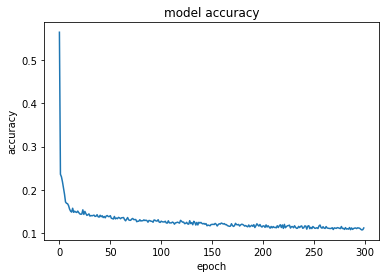

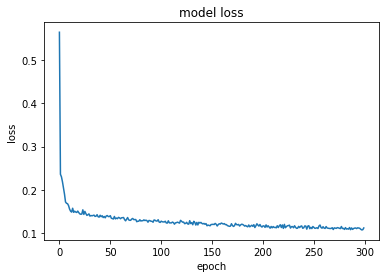

In [8]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict([x_test,x_test_mags_scaled])
#np.argmax(predictions[0])
photoz = []

for i in range(0,len(y_test)):
    photoz.append(predictions[i])

plt.scatter(y_test,photoz)
#plt.title('Photo-z determination')
plt.ylabel('spectro-z')
plt.xlabel('photo-z')
plt.show()


In [ ]:
#model 2 results:

#results with skip connection:

from photoz_utils import *
y_test_new = pd.Series(y_test)
photoz = pd.Series(photoz)
get_point_metrics(photoz,y_test_new)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import matplotlib.cm as cm

# Generate fake data
x = np.array(y_test_new)
y = np.concatenate(photoz, axis = 0)

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

import matplotlib
fig, ax = plt.subplots()
ax_ = ax.scatter(x, y, c=z,s = 1,edgecolor=None, norm=matplotlib.colors.LogNorm())
plt.colorbar(ax_)
plt.xlabel('spectroscopic redshift')
plt.ylabel('photo z')
plt.plot([.176,4],[0,3.25], color='black')
plt.plot([0, 3.348], [.15, 4],color = 'black')
plt.xlim(0,4)
plt.ylim(0,4)

In [12]:
model.save_weights('./checkpoints/my_checkpoint2')



In [ ]:

#Create a new model instance
model = create_model()

# Restore the weights
model.load_weights('./checkpoints/my_checkpoint')